In [1]:
import sys 
print(sys.version)

3.9.5 (default, May 18 2021, 14:42:02) [MSC v.1916 64 bit (AMD64)]


In [3]:
# python version 3.8.6rc1
import pandas as pd
import string
import util
import io
import os
from pprint import pprint
import spacy
import pickle
import re
import numpy as np

import warnings
warnings.filterwarnings(action='once')
#warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Descriptive Analysis

In [4]:
# Count number of rows with each label without considering combination
comments = pd.read_csv("train.csv")
comments.iloc[:, 2:].sum(axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

<AxesSubplot:title={'center':'Labels Frequency'}>

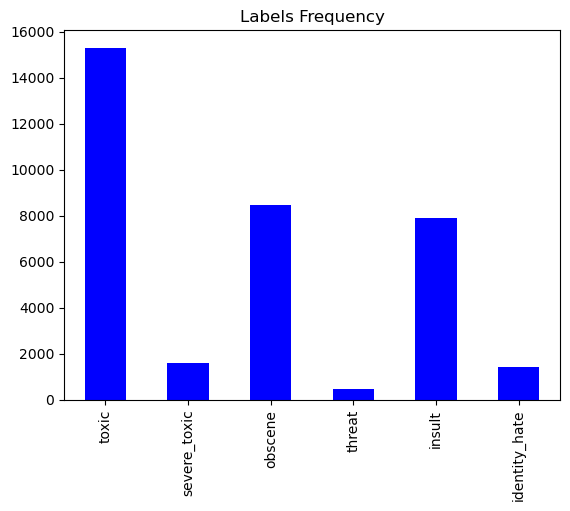

In [5]:
# Label Frequency
train_labels = comments[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()
label_count.plot(kind='bar', title='Labels Frequency', color='b')

In [6]:
# Count number of different combinations
comments[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].value_counts().reset_index(name='count')

,toxic,severe_toxic,obscene,threat,insult,identity_hate,count
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215
5,1,1,1,0,1,0,989
6,1,0,1,0,1,1,618
7,0,0,1,0,0,0,317
8,0,0,0,0,1,0,301
9,1,1,1,0,1,1,265


| Combination | Count |
| --- | --- |
| Toxic | 5666 |
| Toxic + Obscene + Insult | 3800 |
| Toxic + Obscene | 1758 |
| toxic + Insult | 1215 |
| Toxic + Severe Toxic + Obscene + Insult | 989 |
| Toxic + Obscene + Insult + Identity Hate | 618 |
| ... | ... |
| Obscene + Threat + Insult | 2 |
| Obscene + Threat | 2 |
| Toxic + Severe Toxic + Threat + Identity Hate | 1 |
| Toxic + Severe Toxic + Threat + Insult | 1 |


In [7]:
print(comments.iloc[:, 2:].sum(axis=0))
#(comments.iloc[:, 2:].sum())
# merging different kinds of harmful indicators
comments['harmful'] = comments.iloc[:, 2:].sum(axis=1)
#comments[comments['harmful']!=0] = 1




df = comments[['comment_text',"harmful"]]#.copy()

df.loc[df['harmful'] != 0, 'harmful'] = 1

#selected.dtypes

df_harmful = df[df['harmful'] > 0] 
df_not_harmful = df[df['harmful'] == 0]
df.head()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


c:\users\willi\miniconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,comment_text,harmful
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
print(df['harmful'].value_counts())

0    143346
1     16225
Name: harmful, dtype: int64


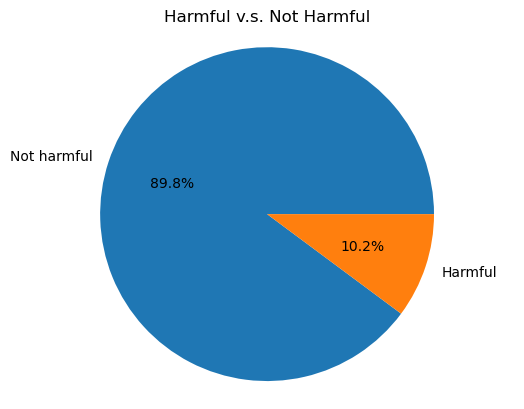

In [9]:
# pie chart for whole dataset
labels = ['Not harmful', 'Harmful']
sizes = [143346, 16225]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Harmful v.s. Not Harmful')


plt.show()

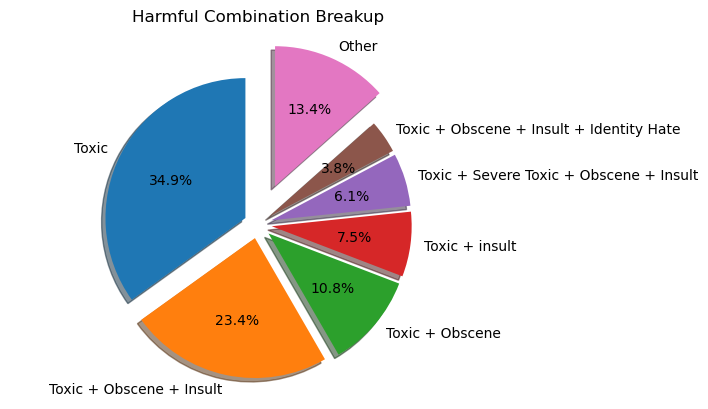

In [10]:
# pie chart Harmful Dataset
labels = ['Toxic', 'Toxic + Obscene + Insult', 'Toxic + Obscene', 'Toxic + insult', 'Toxic + Severe Toxic + Obscene + Insult', 'Toxic + Obscene + Insult + Identity Hate', 'Other']
sizes = [5666, 3800, 1758, 1215, 989, 618, 2179]

explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3)

fig, ax = plt.subplots()
ax.pie(sizes,
       explode=explode,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Harmful Combination Breakup')
plt.show()

# Data Cleaning

In [11]:
def preprocess(df):
    def remove_punctuation(text):
        #return str(text).translate(str.maketrans('', '', string.punctuation))
        text_nopunct = "".join([char if char not in string.punctuation else ' ' for char in str(text)])
        return text_nopunct

    def tokenize_text(text):
        tokens = nltk.word_tokenize(text) 
        tokens = [token.strip() for token in tokens]
        return tokens

    def remove_stopwords(tokens):
        stopword_list = nltk.corpus.stopwords.words('english')
        filtered_tokens = [token for token in tokens if token not in stopword_list]
        #filtered_text = ' '.join(filtered_tokens)    
        return filtered_tokens

    def expand_contractions(text, contraction_mapping):

        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())                       
            expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction

        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text
    
    def remove_digit(text):
        text_nodigit = re.sub(r'\w*\d\w*', '',text).strip()
        return text_nodigit

    def stemming(tokenized_text):
        ps = nltk.PorterStemmer()
        stemmed = [ps.stem(word) for word in tokenized_text]
        return stemmed

    def lemmatize(tokenized_text):
        wn = nltk.WordNetLemmatizer()
        lemmatized = [wn.lemmatize(word) for word in tokenized_text]
        return lemmatized
    
    
    df["expand_contractions"] = df["comment_text"].apply(lambda x: expand_contractions(x.lower(), util.contraction_mapping))
    df["remove_punctuation"] = df["expand_contractions"].apply(lambda x: remove_punctuation(x))
    df["remove_digit"] = df["remove_punctuation"].apply(lambda x: remove_digit(x))
    df["tokenized"] = df["remove_digit"].apply(lambda x: tokenize_text(x))
    df['remove_stopwords'] =  df["tokenized"].apply(lambda x: remove_stopwords(x))
    df['stemmed'] =  df["remove_stopwords"].apply(lambda x: stemming(x))
    df['lemmatized'] =  df["stemmed"].apply(lambda x: lemmatize(x))
    return df

In [12]:
# Randomly select 15% of not harmful instances + all harmful instances
df_not_harmful_sample = df_not_harmful.sample(frac=0.15)
sample_df = pd.concat([df_not_harmful_sample, df_harmful], axis=0)

In [13]:
sample_df

,comment_text,harmful
58196,"""\r\n\r\nWelcome\r\n\r\nHello, and welcome to ...",0
132858,"""\r\n\r\nIt shows in your reverets; which is w...",0
158290,I was always keeping an eye on the page. I was...,0
129410,"""\r\n\r\n November 2011 \r\n\r\nHello and welc...",0
116518,Crucial info such as vehicles and turning it i...,0
...,...,...
159494,"""\r\n\r\n our previous conversation \r\n\r\nyo...",1
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159541,Your absurd edits \r\n\r\nYour absurd edits on...,1
159546,"""\r\n\r\nHey listen don't you ever!!!! Delete ...",1


In [14]:
df_process = preprocess(sample_df)
df_process.head()

,comment_text,harmful,expand_contractions,remove_punctuation,remove_digit,tokenized,remove_stopwords,stemmed,lemmatized
58196,"""\r\n\r\nWelcome\r\n\r\nHello, and welcome to ...",0,"""\r\n\r\nwelcome\r\n\r\nhello, and welcome to ...",\r\n\r\nwelcome\r\n\r\nhello and welcome to ...,welcome\r\n\r\nhello and welcome to wikipedia...,"[welcome, hello, and, welcome, to, wikipedia, ...","[welcome, hello, welcome, wikipedia, thank, co...","[welcom, hello, welcom, wikipedia, thank, cont...","[welcom, hello, welcom, wikipedia, thank, cont..."
132858,"""\r\n\r\nIt shows in your reverets; which is w...",0,"""\r\n\r\nit shows in your reverets; which is w...",\r\n\r\nit shows in your reverets which is w...,it shows in your reverets which is why i aske...,"[it, shows, in, your, reverets, which, is, why...","[shows, reverets, asked, editing, writing, ong...","[show, reveret, ask, edit, write, ongo, thing,...","[show, reveret, ask, edit, write, ongo, thing,..."
158290,I was always keeping an eye on the page. I was...,0,i was always keeping an eye on the page. i was...,i was always keeping an eye on the page i was...,i was always keeping an eye on the page i was...,"[i, was, always, keeping, an, eye, on, the, pa...","[always, keeping, eye, page, staying, away, bl...","[alway, keep, eye, page, stay, away, block, ma...","[alway, keep, eye, page, stay, away, block, ma..."
129410,"""\r\n\r\n November 2011 \r\n\r\nHello and welc...",0,"""\r\n\r\n november 2011 \r\n\r\nhello and welc...",\r\n\r\n november 2011 \r\n\r\nhello and welc...,november \r\n\r\nhello and welcome it might ...,"[november, hello, and, welcome, it, might, not...","[november, hello, welcome, might, intention, r...","[novemb, hello, welcom, might, intent, recent,...","[novemb, hello, welcom, might, intent, recent,..."
116518,Crucial info such as vehicles and turning it i...,0,crucial info such as vehicles and turning it i...,crucial info such as vehicles and turning it i...,crucial info such as vehicles and turning it i...,"[crucial, info, such, as, vehicles, and, turni...","[crucial, info, vehicles, turning, buggies, bu...","[crucial, info, vehicl, turn, buggi, buggi, ex...","[crucial, info, vehicl, turn, buggi, buggi, ex..."


## Percentage of Changing After Each Step

### From Tokenization to Stopwords Removal

In [14]:
# From Tokenization to Stopwords Removal
tokenization = df_process['tokenized'].values.tolist()
count = 0
for words in tokenization:
    count += len(words)
count_srRemoval = 0
stopwords_removal = df_process['remove_stopwords']
for words in stopwords_removal:
    count_srRemoval += len(words)
total_stopwords_removed = count - count_srRemoval
percentage_change_after_sr = total_stopwords_removed / count
print('Total stopwords removed', total_stopwords_removed)
print('Percentage of Change After Stopwords Removal', percentage_change_after_sr)

Total stopwords removed 1138755
Percentage of Change After Stopwords Removal 0.4825801513907147


### From Stopwords Removal to Stemming

In [15]:
# From Stopwords Removal to Stemming
df_process['unchange_SR_Stemming'] = [list(set(a).intersection(set(b))) 
                      for a, b in zip(df_process.remove_stopwords, df_process.stemmed)]

SR = df_process['remove_stopwords'].values.tolist()
count_SR = 0
for words in SR:
    count_SR += len(words)

unchange_SR_Stemming = df_process['unchange_SR_Stemming'].values.tolist()
count_unchange_SR_Stemming = 0
for words in unchange_SR_Stemming:
    count_unchange_SR_Stemming += len(words)

count_change_SR_Stemming = count_SR-count_unchange_SR_Stemming
print('Total words after removing stopwords:', count_SR)
print('Total words that are NOT changed during stemming process:', count_unchange_SR_Stemming)
print('Total words that are changed after stemming process:', count_change_SR_Stemming)
print('Percentage of words that are not changed during stemming process',count_unchange_SR_Stemming/count_SR)
print('Percentage of words that are changed during stemming process', count_change_SR_Stemming/count_SR)

Total words after removing stopwords: 1220967
Total words that are NOT changed during stemming process: 487183
Total words that are changed after stemming process: 733784
Percentage of words that are not changed during stemming process 0.3990140601670643
Percentage of words that are changed during stemming process 0.6009859398329357


### From Stemming to Lemmatization

In [16]:
# From Stemming to Lemmatization
df_process['unchange_Stemming_Lemma'] = [list(set(a).intersection(set(b))) 
                      for a, b in zip(df_process.stemmed, df_process.lemmatized)]

SL = df_process['stemmed'].values.tolist()
count_SL = 0
for words in SL:
    count_SL += len(words)

unchange_Stemming_Lemma = df_process['unchange_Stemming_Lemma'].values.tolist()
count_unchange_Stemming_Lemma = 0
for words in unchange_Stemming_Lemma:
    count_unchange_Stemming_Lemma += len(words)

count_change_Stemming_Lemma = count_SL-count_unchange_Stemming_Lemma
print('Total words after stemming:', count_SL)
print('Total words that are NOT changed during lemmatization process:', count_unchange_Stemming_Lemma)
print('Total words that are changed after lemmatization process:', count_change_Stemming_Lemma)
print('Percentage of words that are not changed during lemmatization process',count_unchange_Stemming_Lemma/count_SL)
print('Percentage of words that are changed during lemmatization process', count_change_Stemming_Lemma/count_SL)

Total words after stemming: 1220967
Total words that are NOT changed during lemmatization process: 864541
Total words that are changed after lemmatization process: 356426
Percentage of words that are not changed during lemmatization process 0.7080789243280121
Percentage of words that are changed during lemmatization process 0.2919210756719879


# LDA

In [15]:
def token_to_corpus(token):
    data_words = token.values.tolist()
    #print(data_words[:1][0][:30])
    id2word = corpora.Dictionary(data_words)
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]  
    return corpus, id2word

def generate_pyLDAvis(corpus, id2word,num_topics = 10, save = False):
    lda_model = LdaModel(corpus = corpus,
                     id2word = id2word,
                     num_topics = num_topics,
                     random_state = 0,
                     chunksize = 100,
                     alpha = "auto",
                     per_word_topics = True,
    )
    LDA_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    if(save):
        pyLDAvis.save_html(LDA_vis, "./results/pyLDAvis.html")
    pprint(lda_model.print_topics())
    return lda_model, LDA_vis

# def get_LDA_conherence(lda_model, document, id2word, method = 'c_v'):
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=document, dictionary=id2word, coherence=method)
#     return coherence_model_lda.get_coherence()

def evaluate_LDA_conherence(document, corpus, id2word,num_topics, method = 'c_v'):
    lda_model = LdaModel(corpus = corpus,
                     id2word = id2word,
                     num_topics = num_topics,
                     random_state = 0,
                     chunksize = 100,
                     alpha = "auto",
                     per_word_topics = True,
    )
    coherence_model_lda = CoherenceModel(model=lda_model, texts=document, dictionary=id2word, coherence=method)
    return coherence_model_lda.get_coherence()



In [40]:
# 
document = df_process['lemmatized'][:100]

simple_corpus, simple_id2word = token_to_corpus(document)
evaluate_LDA_conherence(document, simple_corpus, simple_id2word,num_topics = 10, method = 'c_v')


0.40296645348817756

In [41]:
# determining the performance 

conherence_list = []
range_list = range(2,25)

for n in range_list:
    print('Running topic number of', n)
    conherence_score = evaluate_LDA_conherence(document, simple_corpus, simple_id2word,num_topics = n, method = 'c_v')
    conherence_list.append(conherence_score)
    print(conherence_score)




Running topic number of 2
0.3848415024304605
Running topic number of 3
0.36738690594259427
Running topic number of 4
0.37746864676689296
Running topic number of 5
0.3750640705134182
Running topic number of 6
0.391692652927337
Running topic number of 7
0.38621995843274315
Running topic number of 8
0.38687358705933117
Running topic number of 9
0.4341678514100305
Running topic number of 10
0.40296645348817756
Running topic number of 11
0.3711996528287058
Running topic number of 12
0.39110914604366603
Running topic number of 13
0.38350241297176246
Running topic number of 14
0.39796771382487084
Running topic number of 15
0.37754066349531584
Running topic number of 16
0.39990407834527497
Running topic number of 17
0.3935059868638773
Running topic number of 18
0.3963574183588915
Running topic number of 19
0.4017049852198373
Running topic number of 20
0.4053281339124516
Running topic number of 21
0.3898023307145977
Running topic number of 22
0.37347952751983227
Running topic number of 23
0.370

In [48]:
max_index = range_list[np.array(conherence_list).argmax()]
max_index , conherence_list[max_index]
print('Occur at index:', max_index, '\nBest Coherence Score: ', conherence_list[max_index-2], )

Occur at index: 9 
Best Coherence Score:  0.4341678514100305


In [44]:
# validation on a new dataset
document = df_process['lemmatized'][100:200]

simple_corpus, simple_id2word = token_to_corpus(document)

conherence_score = evaluate_LDA_conherence(document, simple_corpus, simple_id2word,num_topics = max_index, method = 'c_v')
conherence_score

0.44448943745996483

Text(0.5, 1.0, 'LDA performance')

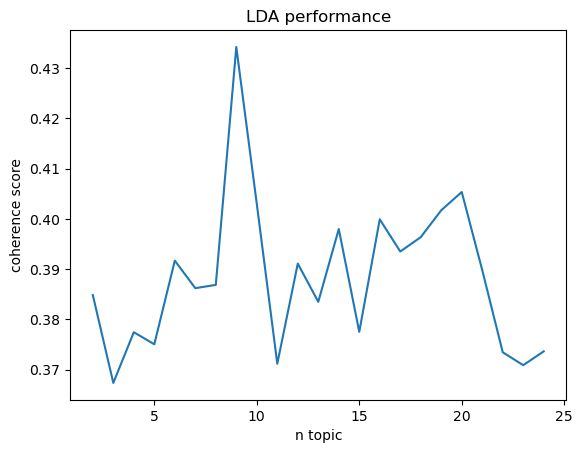

In [49]:
plt.plot(range_list, conherence_list)
plt.xlabel('n topic')
plt.ylabel('coherence score')
plt.title('LDA performance')

In [31]:
# take a look at LDA result
document = df_process['lemmatized'][:100]

simple_corpus, simple_id2word = token_to_corpus(document)
simple_LDA_vis = generate_pyLDAvis(simple_corpus, simple_id2word)
pyLDAvis.enable_notebook()
simple_LDA_vis

[(0,
  '0.011*"tone" + 0.011*"episod" + 0.008*"wp" + 0.008*"userbox" + 0.008*"user" '
  '+ 0.007*"repeat" + 0.006*"go" + 0.005*"articl" + 0.005*"need" + '
  '0.005*"templat"'),
 (1,
  '0.014*"mediat" + 0.013*"talk" + 0.011*"ad" + 0.010*"articl" + 0.009*"page" '
  '+ 0.007*"topic" + 0.007*"watch" + 0.006*"get" + 0.006*"need" + '
  '0.006*"henotheist"'),
 (2,
  '0.018*"page" + 0.012*"work" + 0.011*"articl" + 0.011*"thank" + '
  '0.010*"spiritu" + 0.010*"cooki" + 0.009*"categori" + 0.008*"talk" + '
  '0.008*"thought" + 0.007*"kitson"'),
 (3,
  '0.021*"wikipedia" + 0.020*"delet" + 0.017*"articl" + 0.012*"imag" + '
  '0.012*"see" + 0.012*"leagu" + 0.010*"rank" + 0.009*"soccer" + 0.009*"would" '
  '+ 0.008*"plea"'),
 (4,
  '0.013*"delet" + 0.011*"may" + 0.011*"mani" + 0.010*"articl" + '
  '0.009*"wikipedia" + 0.008*"go" + 0.008*"one" + 0.008*"plea" + 0.007*"case" '
  '+ 0.007*"creat"'),
 (5,
  '0.018*"page" + 0.010*"know" + 0.009*"make" + 0.008*"creat" + 0.008*"would" '
  '+ 0.007*"peopl" + 

(<gensim.models.ldamodel.LdaModel at 0x22ffed183a0>,
 PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
 topic                                                
 9      0.082995 -0.060442       1        1  20.454998
 3      0.070154  0.050664       2        1  12.496636
 2     -0.109971 -0.058516       3        1  11.609795
 8      0.039972  0.089562       4        1  11.160844
 6      0.038692 -0.018689       5        1  10.394947
 4     -0.054262  0.078044       6        1   8.855957
 1     -0.006242 -0.010231       7        1   7.922381
 7     -0.088108  0.022318       8        1   7.859379
 5      0.022702 -0.070586       9        1   5.659151
 0      0.004069 -0.022126      10        1   3.585913, topic_info=           Term       Freq      Total Category  logprob  loglift
 497       delet  29.000000  29.000000  Default  30.0000  30.0000
 35         page  26.000000  26.000000  Default  29.0000  29.0000
 401      mediat   7.000000   7.000000  Default

# Checking the result of 1000 record instead of 100

In [50]:
document = df_process['lemmatized'][:1000]

simple_corpus, simple_id2word = token_to_corpus(document)

conherence_score = evaluate_LDA_conherence(document, simple_corpus, simple_id2word,num_topics = 9, method = 'c_v')


conherence_list = []
range_list = range(2,25)

for n in range_list:
    print('Running topic number of', n)
    conherence_score = evaluate_LDA_conherence(document, simple_corpus, simple_id2word,num_topics = n, method = 'c_v')
    conherence_list.append(conherence_score)
    print(conherence_score)



Running topic number of 2
0.43216879541093667
Running topic number of 3
0.43740745641796175
Running topic number of 4
0.3498952160879182
Running topic number of 5
0.43973517297711284
Running topic number of 6
0.4198988654912558
Running topic number of 7
0.4795349321031752
Running topic number of 8
0.44051039186616314
Running topic number of 9
0.43052177223456417
Running topic number of 10
0.45721144576973904
Running topic number of 11
0.4129164221889567
Running topic number of 12
0.38265410366486813
Running topic number of 13
0.3862256498263547
Running topic number of 14
0.37442248035062964
Running topic number of 15
0.3757308510641347
Running topic number of 16
0.3770219306679272
Running topic number of 17
0.4201194816982387
Running topic number of 18
0.4023949448296537
Running topic number of 19
0.42037345784982233
Running topic number of 20
0.38742702568196635
Running topic number of 21
0.3773059706221464
Running topic number of 22
0.3851776204580318
Running topic number of 23
0.397

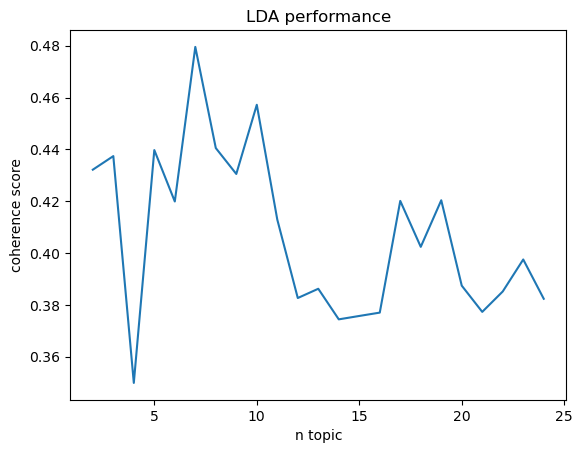

In [58]:

plt.plot(range_list, conherence_list)
plt.xlabel('n topic')
plt.ylabel('coherence score')
plt.title('LDA performance')
plt.show(fig)

In [52]:
max_index = range_list[np.array(conherence_list).argmax()]
max_index , conherence_list[max_index]
print('Occur at index:', max_index, '\nBest Coherence Score: ', conherence_list[max_index-2], )

Occur at index: 7 
Best Coherence Score:  0.4795349321031752


In [59]:
# testing on a new dataset
document = df_process['lemmatized'][2000:3000]

simple_corpus, simple_id2word = token_to_corpus(document)

conherence_score = evaluate_LDA_conherence(document, simple_corpus, simple_id2word,num_topics = max_index, method = 'c_v')
conherence_score

0.4505266459601575

In [65]:
# validation on a new dataset
document = df_process['lemmatized'][4000:5000]

simple_corpus, simple_id2word = token_to_corpus(document)

conherence_score = evaluate_LDA_conherence(document, simple_corpus, simple_id2word,num_topics = max_index, method = 'c_v')
conherence_score

0.4687399090101888

In [67]:
document = df_process['lemmatized']

simple_corpus, simple_id2word = token_to_corpus(document)

conherence_score = evaluate_LDA_conherence(document, simple_corpus, simple_id2word,num_topics = 7, method = 'c_v')
conherence_score

0.4752018170182254

In [68]:
document = df_process['lemmatized']

simple_corpus, simple_id2word = token_to_corpus(document)

conherence_score = evaluate_LDA_conherence(document, simple_corpus, simple_id2word,num_topics = 67, method = 'c_v')
conherence_score

0.38806952547040346